<a href="https://colab.research.google.com/github/AliAkbarBadri/topics-for-types/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# data

In [3]:
! ls "/content/drive/My Drive/topics-for-types/"

df_topics.csv  df_types.csv  result.csv  sample-acmsmall.pdf


In [4]:
df_topics = pd.read_csv("/content/drive/My Drive/topics-for-types/df_topics.csv")
df_topics.head()

,sentence,اقتصاد,بازی,برنامه‌نویسی,تحصیل,تغذیه,حقوق/قانون,حیوانات,خرید,روابط,روانشناسی,زبان,زیبایی,سرگرمی,سفر,سلامت,فنی,ماشین,مذهبی,ورزش,کار,کامپیوتر/موبایل,کودکان,گیاهان
0,تفاوت ترمز عقب دیسکی و کاسه ای چیست؟,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,آیا ترمز ضدقفل ABS در همه چرخ ها عمل می کند؟,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,چرا باوجود نصب بودن ترمز ABS بر روی خودرو، ترم...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,چرا با وجود نصب بودن Airbag بر روی خودرو، در ه...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,کلاس های مختلف خودرو چگونه شناسایی می شوند؟,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


In [5]:
df_types = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types.csv")
df_types.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,تفاوت ترمز عقب دیسکی و کاسه ای چیست؟,0,0,0,0,1,1,0,0,0,1,0,0
1,آیا ترمز ضدقفل ABS در همه چرخ ها عمل می کند؟,0,1,0,0,0,1,0,0,0,1,0,0
2,چرا باوجود نصب بودن ترمز ABS بر روی خودرو، ترم...,0,0,0,0,0,1,1,0,0,1,0,0
3,چرا با وجود نصب بودن Airbag بر روی خودرو، در ه...,0,0,0,0,0,1,1,0,0,1,0,0
4,کلاس های مختلف خودرو چگونه شناسایی می شوند؟,0,0,0,0,1,0,0,0,1,1,0,0


# Model

## Load fasttext

In [ ]:
# ! pip -q install parsivar

# from parsivar import *
# parsivar_normalizer = Normalizer()
# parsivar_tokenizer = Tokenizer()

# parsivar_tokenizer.tokenize_sentences(parsivar_normalizer.normalize((
#     """سلام.حال و احوال.چه خبر."""
# )))

In [11]:
# X_topics = []
# sentences = list(toxic_comments["comment_text"])
# for sen in sentences:
#     X_topics.append(preprocess_text(sen))

# y = toxic_comments_labels.values

In [6]:
X = df_types[df_types.columns[0]].values
Y = df_types[df_types.columns[1:]].values

In [7]:
X[:10]

array(['تفاوت ترمز عقب دیسکی و کاسه ای چیست؟ ',
       'آیا ترمز ضدقفل ABS در همه چرخ ها عمل می کند؟  ',
       'چرا باوجود نصب بودن ترمز ABS بر روی خودرو، ترمز ضدقفل عمل نمی کند؟',
       'چرا با وجود نصب بودن Airbag بر روی خودرو، در هنگام تصادف، کیسه هوای ایمنی عمل نکرد؟',
       'کلاس های مختلف خودرو چگونه شناسایی می شوند؟ ',
       'چگونه می توان بر روی خودروهای تولید ایران خودرو آپشن های اضافی درخواست و نصب کرد؟ ',
       'آیا می توان تجهیزاتی مانند ترمز ABS، گیربکس اتوماتیک و کیسه هوا را روی خودرو نصب کرد؟ ',
       'آیا شرکت ایران خودرو برای خودروهای اتومات خدمات پس از فروش دارد؟ ',
       'درباره کد کلاس های خودروهایی که به صورت گروه خودرو معرفی شده اند توضیح دهید؟ ',
       'رنگ های خاص و سفارشی موجود در ایران خودرو، چه رنگ هایی می باشند؟ '],
      dtype=object)

In [8]:
Y[:10]

array([[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]])

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [21]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [22]:
X_train.shape

(1939, 200)

In [13]:
# import pickle

# pickle_in = open("drive/My Drive/nlp/similarity/embeddings/fasttext_twitt_wiki_ham_blog.pickle","rb")
# embeddings_dict = pickle.load(pickle_in)

In [23]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('drive/My Drive/nlp/similarity/embeddings/twitt_wiki_ham_blog.fa.text.100.vec', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [24]:
print(embeddings_dictionary['و'])

[-2.222517 -0.428454 -1.253941  1.551816 -0.450873  2.649759 -1.07392
  0.406471 -1.016656  0.639931 -0.24969  -0.256207  2.047839 -0.139004
  2.443881 -2.85783  -2.349114 -0.481083 -0.138462  1.582742 -0.23184
 -3.487877 -1.008129 -1.740662  1.301929 -0.497582 -1.897205  0.871072
 -4.947224  0.300258  3.44793   1.904012  0.126853  0.94079  -0.677725
  0.112498  0.333517 -1.833528  0.391443  1.316889 -0.229213 -2.983886
  2.828554  5.009136 -4.385108  1.408675 -3.693358 -0.689139 -0.793945
 -0.98941   0.708806 -0.387987  2.559047 -3.488382 -0.513087 -1.142355
 -0.297812 -1.609838 -2.724513  0.776761 -1.8403    0.693504 -1.936019
 -3.0206    1.102566  2.473104 -1.330484 -0.189547 -2.518092  0.153484
  1.032132  0.840575 -2.495274 -1.533112  2.027918  0.139619  0.710635
  2.268173  2.209062 -0.910259  1.784887  2.117979 -1.443968  1.68699
 -1.255109  0.657385 -0.284593 -3.734695 -0.227355  0.455545 -0.74898
  1.158716 -1.366242 -3.442508 -1.246078  1.401888  0.353083  0.361452
  1.804778

In [25]:
embedding_matrix[1]

array([-2.22251701, -0.42845401, -1.25394106,  1.55181599, -0.45087299,
        2.64975905, -1.07392001,  0.40647101, -1.01665604,  0.63993102,
       -0.24969   , -0.25620699,  2.04783893, -0.13900401,  2.44388103,
       -2.85783005, -2.34911394, -0.48108301, -0.13846201,  1.58274198,
       -0.23184   , -3.48787689, -1.008129  , -1.74066198,  1.301929  ,
       -0.49758199, -1.897205  ,  0.87107199, -4.94722414,  0.30025801,
        3.4479301 ,  1.90401196,  0.126853  ,  0.94079   , -0.67772502,
        0.112498  ,  0.33351699, -1.83352804,  0.39144301,  1.31688905,
       -0.229213  , -2.983886  ,  2.82855392,  5.0091362 , -4.38510799,
        1.40867496, -3.69335794, -0.68913901, -0.79394501, -0.98940998,
        0.70880598, -0.38798699,  2.55904698, -3.4883821 , -0.51308697,
       -1.14235497, -0.29781201, -1.60983801, -2.72451305,  0.776761  ,
       -1.84029996,  0.69350398, -1.93601894, -3.02060008,  1.102566  ,
        2.473104  , -1.33048403, -0.189547  , -2.51809192,  0.15

In [48]:
deep_inputs = Input(shape=(maxlen,), name='input_layer')
embedding_layer = Embedding(input_dim=vocab_size, output_dim = 100, 
                            weights=[embedding_matrix],
                            trainable=False, name='embedding_layer')(deep_inputs)

# layer = tf.keras.layers.Embedding(vocab_size, 100, trainable=False)
# layer.build((None, vocab_size))  
# layer.set_weights([embedding_matrix])
# embedding_layer = layer(deep_inputs)

# embedding_layer.set_weights()
# model.add(SpatialDropout1D(0.2))
# LSTM_Layer_1 = LSTM(128, name='LSTM_layer_1',return_sequences=True)(embedding_layer)
# LSTM_Layer_2 = LSTM(512, name='LSTM_layer_2')(LSTM_Layer_1)
LSTM_Layer_1 = LSTM(20, name='LSTM_layer_1')(embedding_layer)
dense_layer_1 = Dense(12, activation='sigmoid', name='Dense_layer')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=64, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
25/25 [==============================] - 1s 28ms/step - loss: 0.6750 - acc: 0.4765 - val_loss: 0.6261 - val_acc: 0.4588
Epoch 2/20
25/25 [==============================] - 0s 12ms/step - loss: 0.4943 - acc: 0.4952 - val_loss: 0.4076 - val_acc: 0.4588
Epoch 3/20
25/25 [==============================] - 0s 12ms/step - loss: 0.3699 - acc: 0.4952 - val_loss: 0.3440 - val_acc: 0.4588
Epoch 4/20
25/25 [==============================] - 0s 12ms/step - loss: 0.3264 - acc: 0.4952 - val_loss: 0.3170 - val_acc: 0.4588
Epoch 5/20
25/25 [==============================] - 0s 13ms/step - loss: 0.3087 - acc: 0.4952 - val_loss: 0.3072 - val_acc: 0.4588
Epoch 6/20
25/25 [==============================] - 0s 14ms/step - loss: 0.3013 - acc: 0.4952 - val_loss: 0.3020 - val_acc: 0.4588
Epoch 7/20
25/25 [==============================] - 0s 14ms/step - loss: 0.2974 - acc: 0.4952 - val_loss: 0.2995 - val_acc: 0.4588
Epoch 8/20
25/25 [==============================] - 0s 13ms/step - loss: 0.2953 - a

In [ ]:
# model.summary()
# ku.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

Epoch 1/5
25/25 [==============================] - 1s 28ms/step - loss: 4.7237 - acc: 0.4765 - val_loss: 4.5383 - val_acc: 0.4588
Epoch 2/5
25/25 [==============================] - 0s 12ms/step - loss: 3.9236 - acc: 0.4952 - val_loss: 3.4530 - val_acc: 0.4588
Epoch 3/5
25/25 [==============================] - 0s 12ms/step - loss: 3.5021 - acc: 0.4952 - val_loss: 3.5704 - val_acc: 0.4588
Epoch 4/5
25/25 [==============================] - 0s 12ms/step - loss: 3.5732 - acc: 0.4952 - val_loss: 3.6232 - val_acc: 0.4588
Epoch 5/5
25/25 [==============================] - 0s 12ms/step - loss: 3.6141 - acc: 0.4952 - val_loss: 3.6570 - val_acc: 0.4588


In [43]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

16/16 [==============================] - 0s 7ms/step - loss: 0.2956 - acc: 0.4866
Test Score: 0.29561036825180054
Test Accuracy: 0.4865979254245758


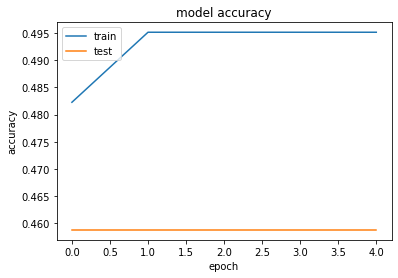

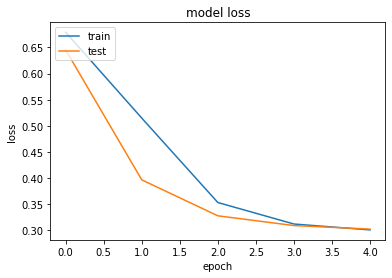

In [44]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# LASER

In [49]:
! pip -q install laserembeddings
! python -m laserembeddings download-models

     |████████████████████████████████| 860kB 4.8MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 

✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

✨ You're all set!


In [50]:
from laserembeddings import Laser
from __future__ import unicode_literals
laser = Laser()

In [101]:
embedding = laser.embed_sentences("سلام خوبی آقا", lang='fa')[0]

In [111]:
embedding

array([ 0.00014774,  0.00062283, -0.00174818, ...,  0.0018397 ,
       -0.00272097, -0.00090287], dtype=float32)

In [164]:
df_types = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types.csv")

In [165]:
df_types['sentence'] = df_types['sentence'].apply(lambda sent: laser.embed_sentences(sent, lang='fa')[0])

In [166]:
df_types.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[0.020942228, -8.114154e-05, -0.0009854127, 0....",0,0,0,0,1,1,0,0,0,1,0,0
1,"[0.008679963, 0.0027223488, -0.000162347, 0.01...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[0.011158587, 0.01838572, -8.3516294e-05, 0.01...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[0.00957515, 0.013646437, 7.700363e-05, 0.0117...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[0.027029112, 0.0024084542, 0.0004833732, 0.00...",0,0,0,0,1,0,0,0,1,1,0,0


In [179]:
X = df_types[df_types.columns[0]].values
Y = df_types[df_types.columns[1:]].values

(1024,)

In [153]:
X=np.array(X)
Y=np.asarray(Y)

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [181]:
len(X_train),len(X_test),len(y_train),len(y_test)

(1939, 485, 1939, 485)

In [182]:
deep_inputs = Input(shape=X.shape, name='input_layer')
# embedding_layer = Embedding(input_dim=vocab_size, output_dim = 100, 
#                             weights=[embedding_matrix],
#                             trainable=False, name='embedding_layer')(deep_inputs)

dense_layer = Dense(12, activation='sigmoid', name='Dense_layer')(deep_inputs)
model = Model(inputs=deep_inputs, outputs=dense_layer)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [183]:
history = model.fit(X_train, y_train, batch_size=64, epochs=5, verbose=1, validation_split=0.2)

ValueError: ignored